In [1]:
!pip install torch_geometric
import os
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv

**Data Preparation**

In [2]:
#graph dataset
dataset=Planetoid(root="data/Planetoid", name="Cora", transform=NormalizeFeatures())

print(f"dataset: {dataset}")
print(f"Number of graphs: {len(dataset)}")
print(f"Number of features: {dataset.num_features}")
print(f"Number of classes: {dataset.num_classes}")
print("================================================")

data=dataset[0]
print(data)
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Number of train nodes: {data.train_mask.sum()}")
print(f"Number of valid nodes: {data.val_mask.sum()}")
print(f"Number of test nodes: {data.test_mask.sum()}")

dataset: Cora()
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Number of train nodes: 140
Number of valid nodes: 500
Number of test nodes: 1000


**Train GNN**

In [3]:
#model definition
class GCN(torch.nn.Module):
  def __init__(self, hidden_channels):
    super().__init__()
    torch.manual_seed(12345)
    self.conv1=GCNConv(dataset.num_features, hidden_channels)
    self.conv2=GCNConv(hidden_channels, dataset.num_classes)

  def forward(self, x, edge_index):
    x=self.conv1(x,edge_index)
    x=x.relu()
    x=F.dropout(x, p=0.5, training=self.training) #trainモードの時のみ
    x=self.conv2(x,edge_index)
    return x

model=GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


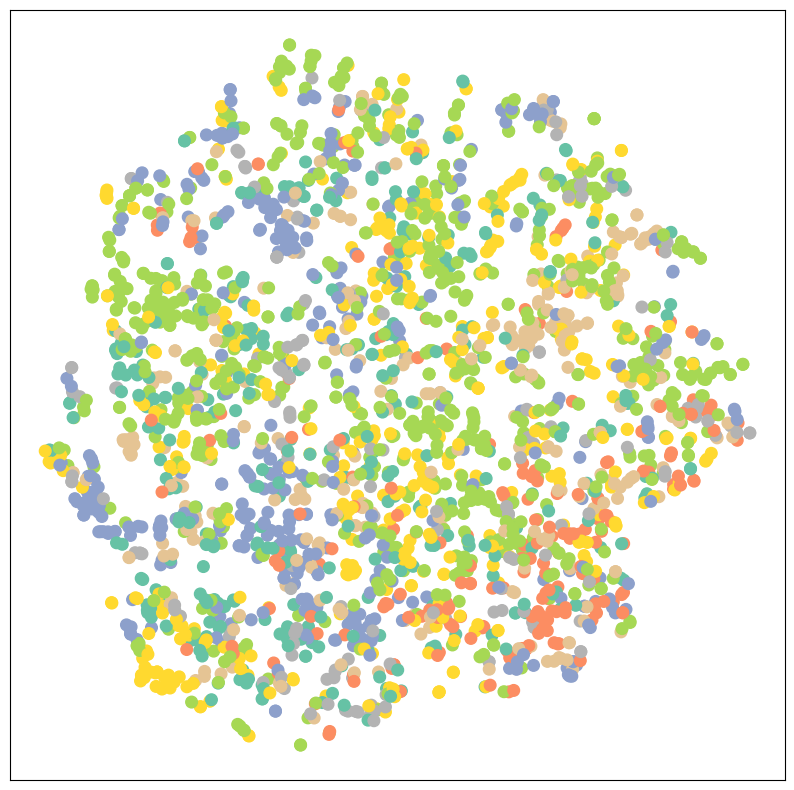

In [4]:
#view node embeddings of untrained GCN
model.eval()
out=model(data.x, data.edge_index)

z=TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())
plt.figure(figsize=(10,10))
plt.xticks([])
plt.yticks([])
plt.scatter(z[:, 0], z[:, 1], s=70, c=data.y, cmap="Set2")
plt.show()

In [5]:
#training
model=GCN(hidden_channels=16)
optimizer=torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion=nn.CrossEntropyLoss()
epochs=200

for epoch in range(epochs):
  model.train()
  optimizer.zero_grad()
  out=model(data.x, data.edge_index)
  loss=criterion(out[data.train_mask], data.y[data.train_mask])
  loss.backward()
  optimizer.step()
  print(f"Epoch: {epoch+1} , Loss: {loss:.4f}")

Epoch: 1 , Loss: 1.9460
Epoch: 2 , Loss: 1.9412
Epoch: 3 , Loss: 1.9363
Epoch: 4 , Loss: 1.9308
Epoch: 5 , Loss: 1.9216
Epoch: 6 , Loss: 1.9137
Epoch: 7 , Loss: 1.9078
Epoch: 8 , Loss: 1.8986
Epoch: 9 , Loss: 1.8868
Epoch: 10 , Loss: 1.8825
Epoch: 11 , Loss: 1.8701
Epoch: 12 , Loss: 1.8614
Epoch: 13 , Loss: 1.8486
Epoch: 14 , Loss: 1.8323
Epoch: 15 , Loss: 1.8344
Epoch: 16 , Loss: 1.8186
Epoch: 17 , Loss: 1.8031
Epoch: 18 , Loss: 1.7980
Epoch: 19 , Loss: 1.7813
Epoch: 20 , Loss: 1.7766
Epoch: 21 , Loss: 1.7478
Epoch: 22 , Loss: 1.7385
Epoch: 23 , Loss: 1.7304
Epoch: 24 , Loss: 1.7120
Epoch: 25 , Loss: 1.7010
Epoch: 26 , Loss: 1.6917
Epoch: 27 , Loss: 1.6672
Epoch: 28 , Loss: 1.6382
Epoch: 29 , Loss: 1.6474
Epoch: 30 , Loss: 1.6297
Epoch: 31 , Loss: 1.6014
Epoch: 32 , Loss: 1.5760
Epoch: 33 , Loss: 1.5732
Epoch: 34 , Loss: 1.5705
Epoch: 35 , Loss: 1.5443
Epoch: 36 , Loss: 1.5131
Epoch: 37 , Loss: 1.4721
Epoch: 38 , Loss: 1.4774
Epoch: 39 , Loss: 1.4380
Epoch: 40 , Loss: 1.4553
Epoch: 41

**Test and view result**

In [6]:
#test accuracy
model.eval()
out=model(data.x, data.edge_index)
pred=out.argmax(dim=1)
correct=pred[data.test_mask]==data.y[data.test_mask]
accuracy=int(correct.sum())/int(data.test_mask.sum())
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8080


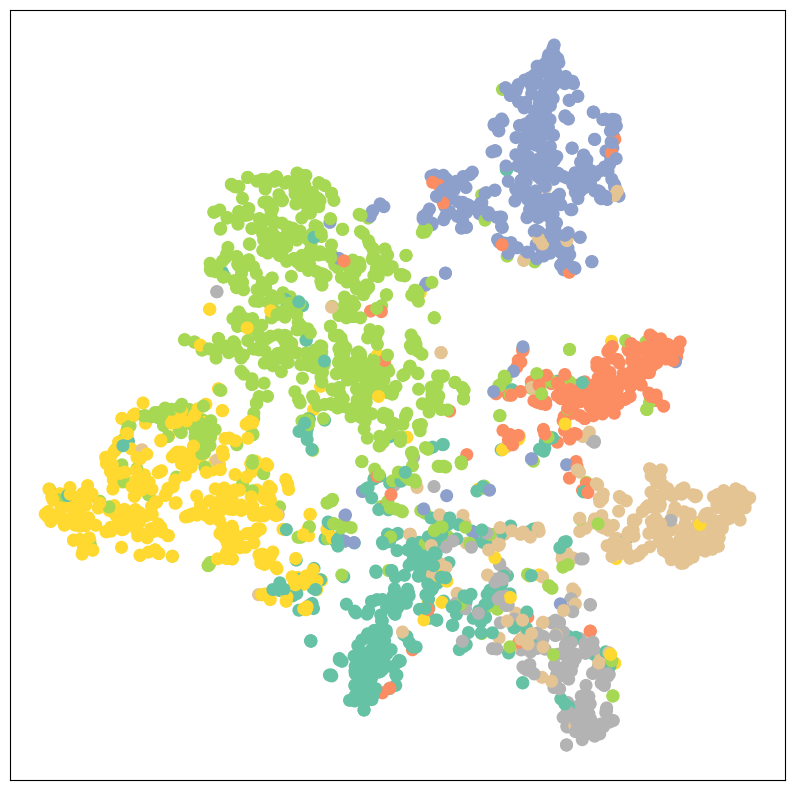

In [7]:
#view node embeddings of trained GCN
model.eval()
out=model(data.x, data.edge_index)

z=TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())
plt.figure(figsize=(10,10))
plt.xticks([])
plt.yticks([])
plt.scatter(z[:, 0], z[:, 1], s=70, c=data.y, cmap="Set2")
plt.show()